In [1]:
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
import statistics as stat

from matplotlib.font_manager import FontProperties
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.cluster import AgglomerativeClustering
from sklearn import manifold
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
from abc import ABCMeta, abstractmethod

%matplotlib inline
plt.rcParams['axes.unicode_minus']=False
engine = create_engine('sqlite:///tw50_2018.db')

In [2]:
class ProfitVisualize(metaclass=ABCMeta):
    
    '''
    input:
        month_NAV：該月所有淨值
        random_names：基金池的所有基金名
    output:
        整理出的features
        與features對齊的基金名
    '''
    @abstractmethod
    def getFeatures(self, month_NAV,random_names):
        pass
    
    '''
    input:整理出的features
    output:聚類過的資料
    '''
    @abstractmethod
    def doClustering(self, features):
        pass
    
    def getProfitPicture(self):
        month_data = pd.read_sql(sql='select * from price where date between "2018-01-01" and "2018-01-31" order by date asc',
                                 con=engine,index_col='date')
        random_names = pd.read_sql(sql='select distinct id from price',con=engine,index_col='id').index
        month_date = pd.read_sql(sql='select distinct date from price where date between "2018-01-01" and "2018-01-31" order by date asc',
                                 con=engine,index_col='date').index
        month_NAV = np.zeros((len(random_names),len(month_date)))
        for j in range (len(random_names)):
            temp = month_data[month_data['id'] == random_names[j]]
            month_NAV[j][0] = temp.iloc[0]['NAV']
            for i,day in enumerate(month_date[1:]):
                try:
                    month_NAV[j][i+1] = temp.loc[day]['NAV']
                except:
                    month_NAV[j][i+1] = month_NAV[j][i]
        
        features,random_names,dissimilarity = self.getFeatures(month_NAV,random_names)
        clustering = self.doClustering(features)
        mds = MDS(n_components=2, dissimilarity=dissimilarity, n_jobs=8).fit(features).embedding_
        
        plt.figure(figsize=(15, 15))
        plt.subplots_adjust(bottom=0.1)
        plt.scatter(mds[:, 0], mds[:, 1], c=clustering.labels_)
        for label, x, y in zip(random_names, mds[:, 0], mds[:, 1]):
            plt.annotate(
            label,
            xy=(x, y), xytext=(-3, 3),
            textcoords='offset points', ha='right', va='bottom')
        plt.show()
        
        data = pd.read_sql(sql='select * from price_ad order by date asc',
                           con=engine,index_col='date')
        camp = pd.DataFrame(data=clustering.labels_, index=random_names,columns=['label'])
        choose_name = []
        for i in range(4):
            choose_name.append(camp[camp['label'] == i].sample(n=1).index[0])
        choose_name.append('0050 元大台灣50')
        year_date = pd.read_sql(sql='select distinct date from price_ad order by date asc',
                                con=engine,index_col='date').index
        year_date_len = len(year_date)
        year_NAV = np.zeros((5,year_date_len))
        for j in range (5):
            temp = data[data['id'] == choose_name[j]]
            year_NAV[j][0] = temp.iloc[0]['NAV']
            for i,day in enumerate(year_date[1:]):
                try:
                    year_NAV[j][i+1] = temp.loc[day]['NAV']
                except:
                    year_NAV[j][i+1] = year_NAV[j][i]
        choose_profit = []
        compare__profit = []
        start = (year_NAV[0][0] + year_NAV[1][0] + year_NAV[2][0] + year_NAV[3][0])/4
        for i in range(year_date_len):
            temp = (year_NAV[0][i] + year_NAV[1][i] + year_NAV[2][i] + year_NAV[3][i])/4
            temp = (temp-start)/start*100
            choose_profit.append(temp)
            compare__profit.append((year_NAV[4][i]-year_NAV[4][0])/year_NAV[4][0]*100)
            
        plt.figure(figsize=(14, 14))
        plt.ylabel('收益率')
        plt.title('收益率對比')
        plt.plot(choose_profit)
        plt.plot(compare__profit)
        plt.legend(['Choose','Compare'])
        plt.show()

In [3]:
class ClusterStrategy(metaclass=ABCMeta):
    @abstractmethod
    def Clustering(self,features):
        pass

In [4]:
class ClusterMethod:
    def __init__(self, clusterStrategy):
        self.clusterStrategy = clusterStrategy
    
    def startClustering(self,features):
        return self.clusterStrategy.Clustering(features)

In [5]:
class K_Means(ClusterStrategy):
    def Clustering(self,features):
        return KMeans(n_clusters=4).fit(features)

In [6]:
class Hierarchical(ClusterStrategy):
    def Clustering(self,features):
        return AgglomerativeClustering(n_clusters=4).fit(features)

In [7]:
# 實作框架

In [8]:
'''
每日漲跌幅
'''
class UpDownRate(ProfitVisualize):

    def __init__(self,clusterStrategy):
        self.clusterStrategy = clusterStrategy
        
    def getFeatures(self, month_NAV,random_names):
        length = len(month_NAV[0])-1
        month_rate = np.zeros((len(random_names),length))
        for j in range (len(random_names)):
            for i in range (length):
                month_rate[j][i] = (month_NAV[j][i+1] - month_NAV[j][i]) / month_NAV[j][i]
        return month_rate,random_names,'euclidean'
    
    def doClustering(self, features):
        return ClusterMethod(self.clusterStrategy).startClustering(features)

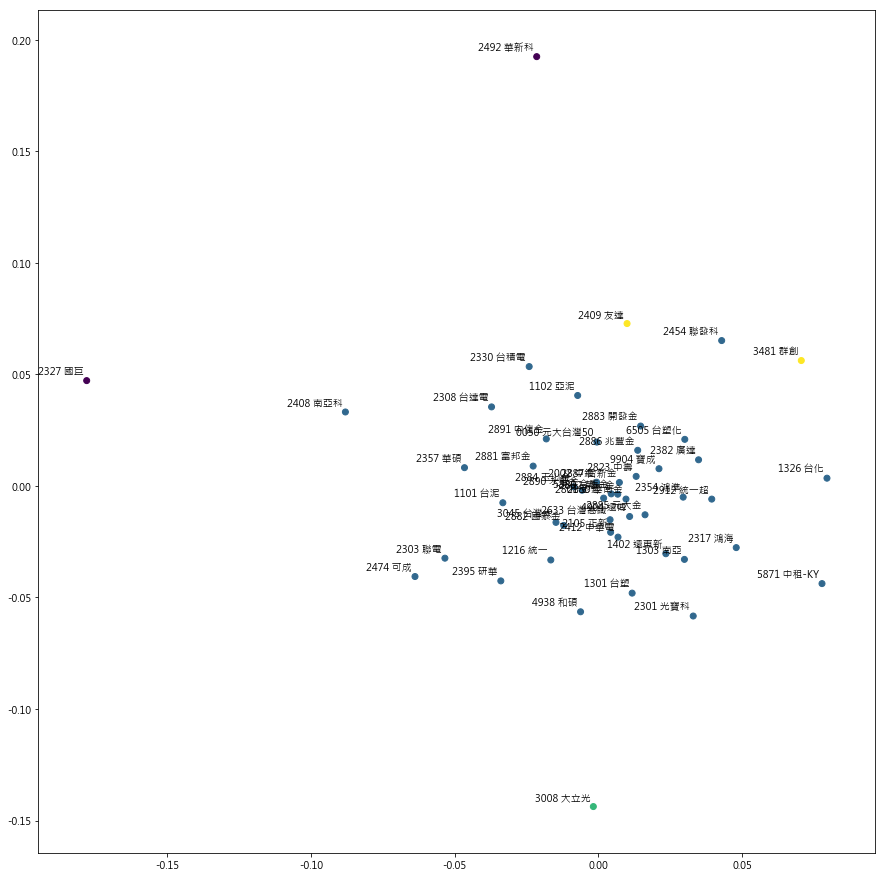

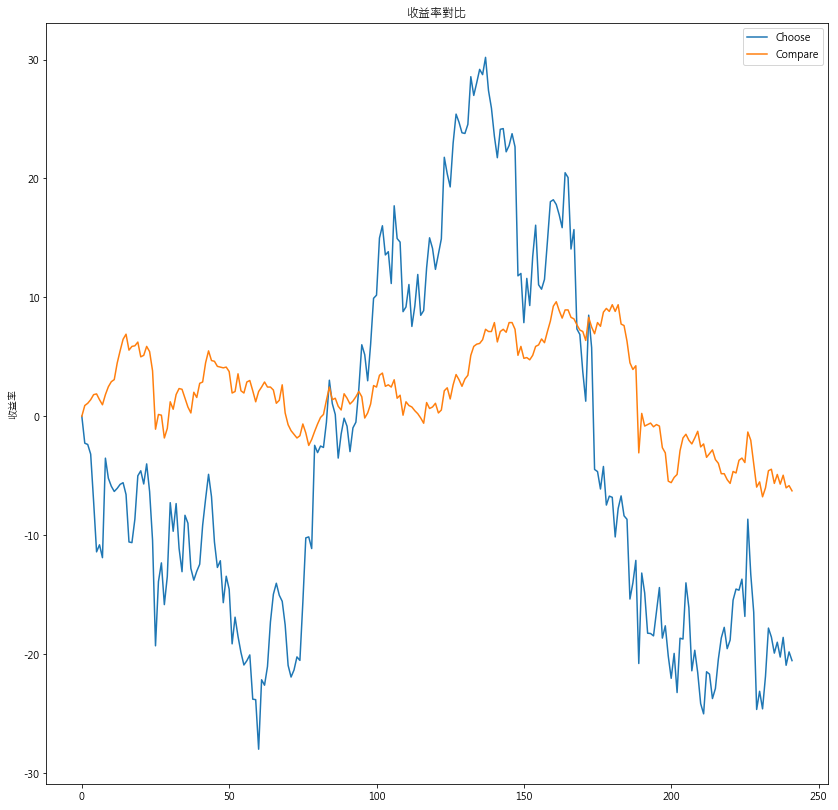

In [9]:
profitVisualize = UpDownRate(K_Means())
profitVisualize.getProfitPicture()

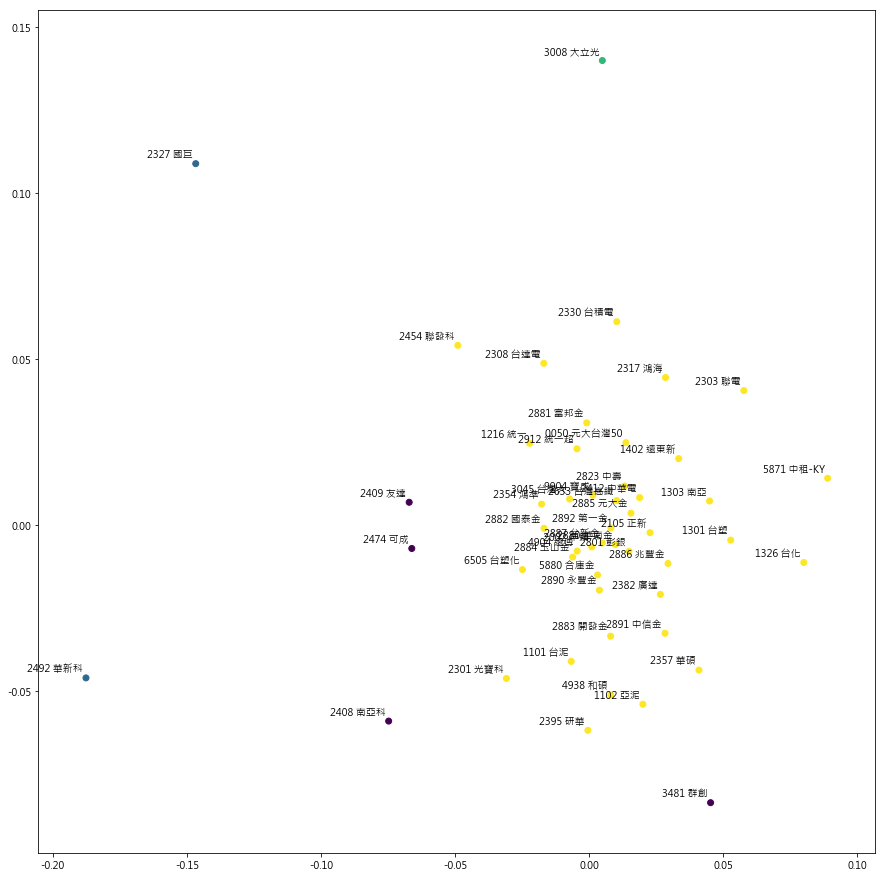

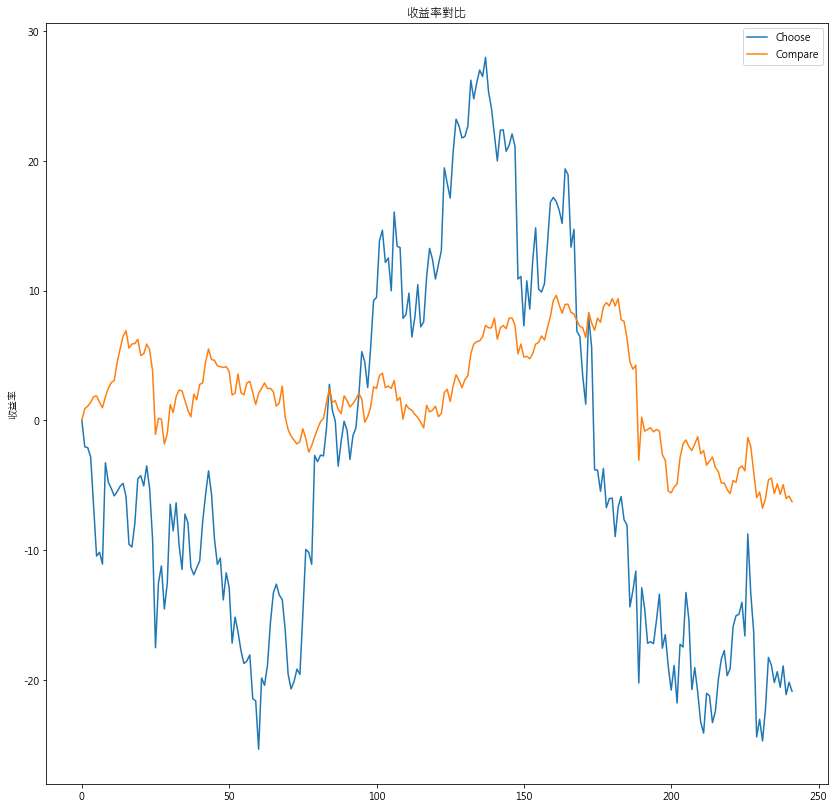

In [10]:
profitVisualize = UpDownRate(Hierarchical())
profitVisualize.getProfitPicture()

In [11]:
'''
相關係數
'''

class Similarity(ProfitVisualize):

    def __init__(self,clusterStrategy):
        self.clusterStrategy = clusterStrategy
        
    def getFeatures(self, month_NAV, random_names):
        length = len(month_NAV[0])-1
        month_rate = np.zeros((len(random_names),length))
        for j in range (len(random_names)):
            for i in range (length):
                month_rate[j][i] = (month_NAV[j][i+1] - month_NAV[j][i]) / month_NAV[j][i]
        
        temp = []
        for i,j in enumerate(month_rate):                        
            if np.cov(j) == 0:
                temp.append(i)
                
        month_rate = np.delete(month_rate,temp,0)
        random_names = np.delete(random_names,temp,0)
        
        similarity = np.zeros((len(month_rate),len(month_rate)))
        for i in range(len(month_rate)):
            for j in range(len(month_rate)):
                corr = np.corrcoef(month_rate[i],month_rate[j])[0][-1]
                if i == j:
                    corr = 1
                similarity[i][j] = 1-(corr*0.5+0.5)
                
        return similarity,random_names,'precomputed'
    
    def doClustering(self, features):
        return ClusterMethod(self.clusterStrategy).startClustering(features)

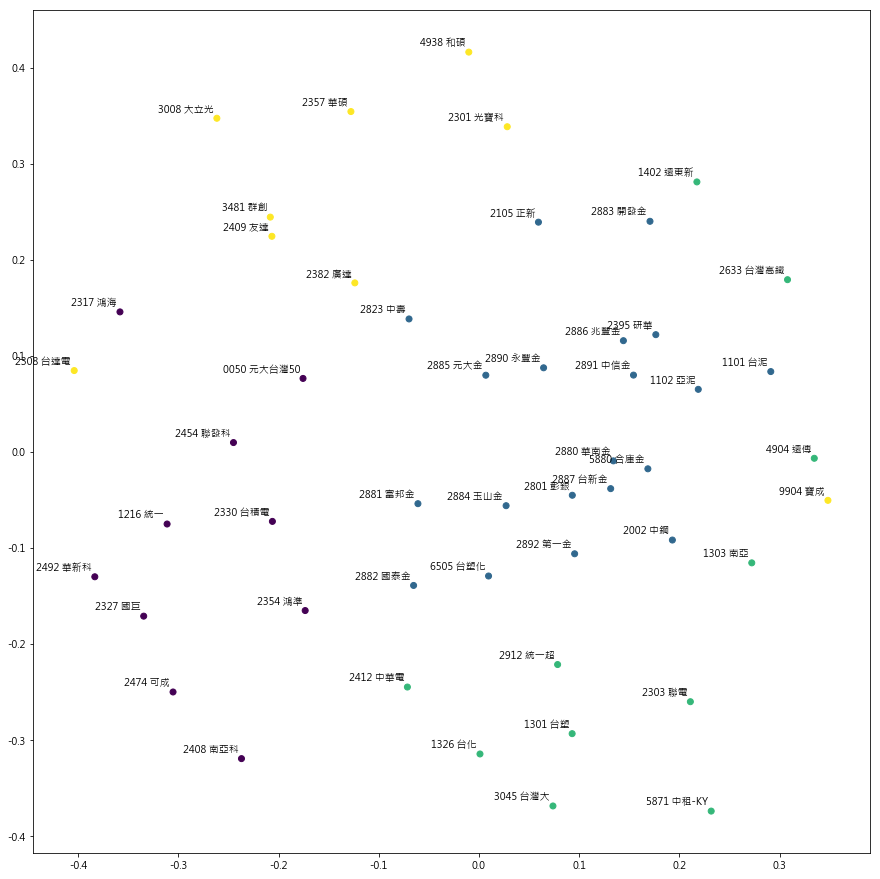

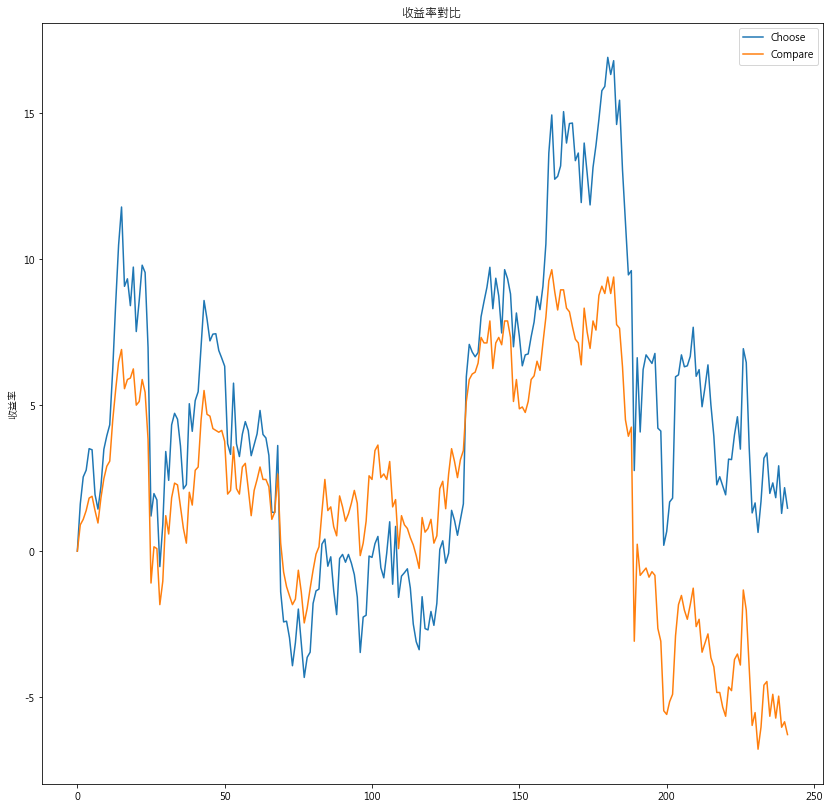

In [12]:
profitVisualize = Similarity(K_Means())
profitVisualize.getProfitPicture()

/home/xiangli/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


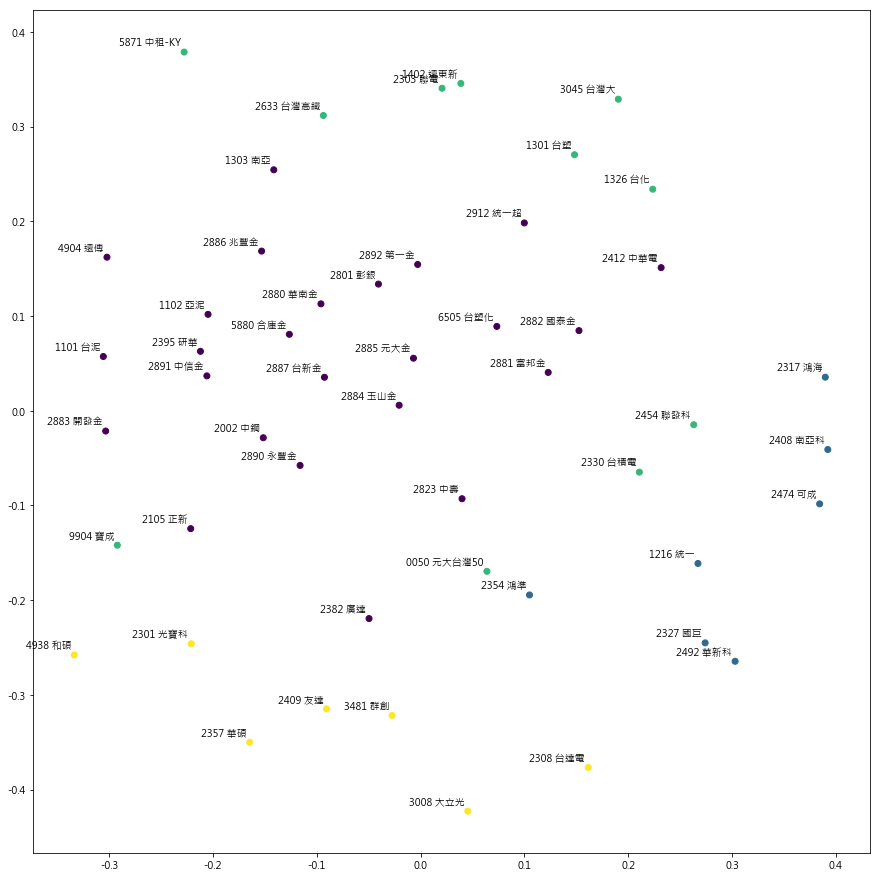

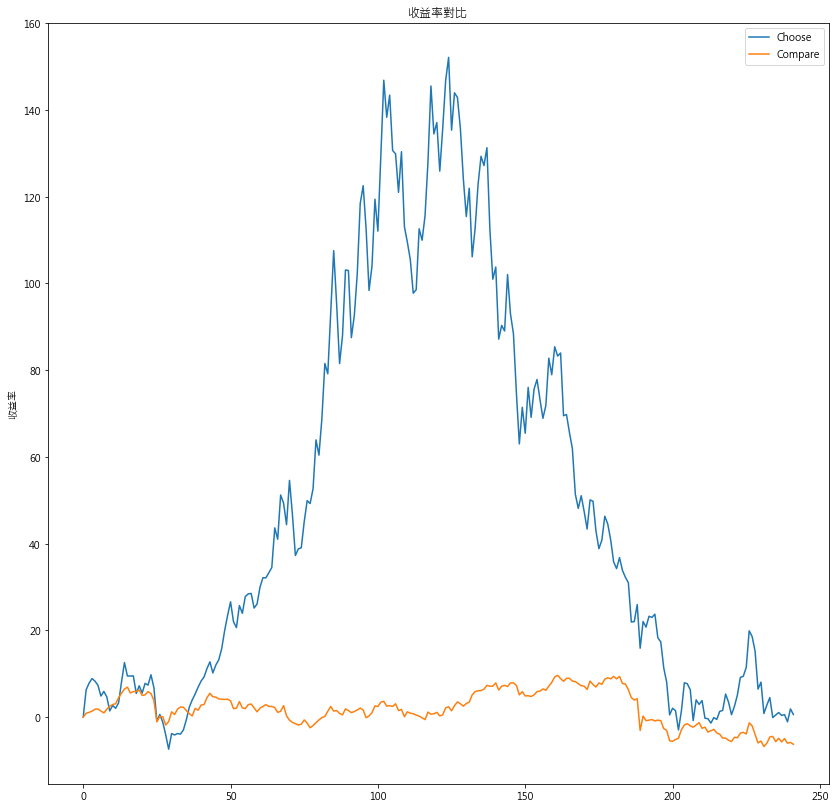

In [13]:
profitVisualize = Similarity(Hierarchical())
profitVisualize.getProfitPicture()

In [14]:
'''
平均數
'''

class Mean(ProfitVisualize):

    def __init__(self,clusterStrategy):
        self.clusterStrategy = clusterStrategy
        
    def getFeatures(self, month_NAV,random_names):
        features = pd.DataFrame(month_NAV)
        for i in features:
            features.iloc[i] = (features.iloc[i]-(stat.mean(features.iloc[i].values)))/features.iloc[i]
        
        return features,random_names,'euclidean'
    
    def doClustering(self, features):
        return ClusterMethod(self.clusterStrategy).startClustering(features)

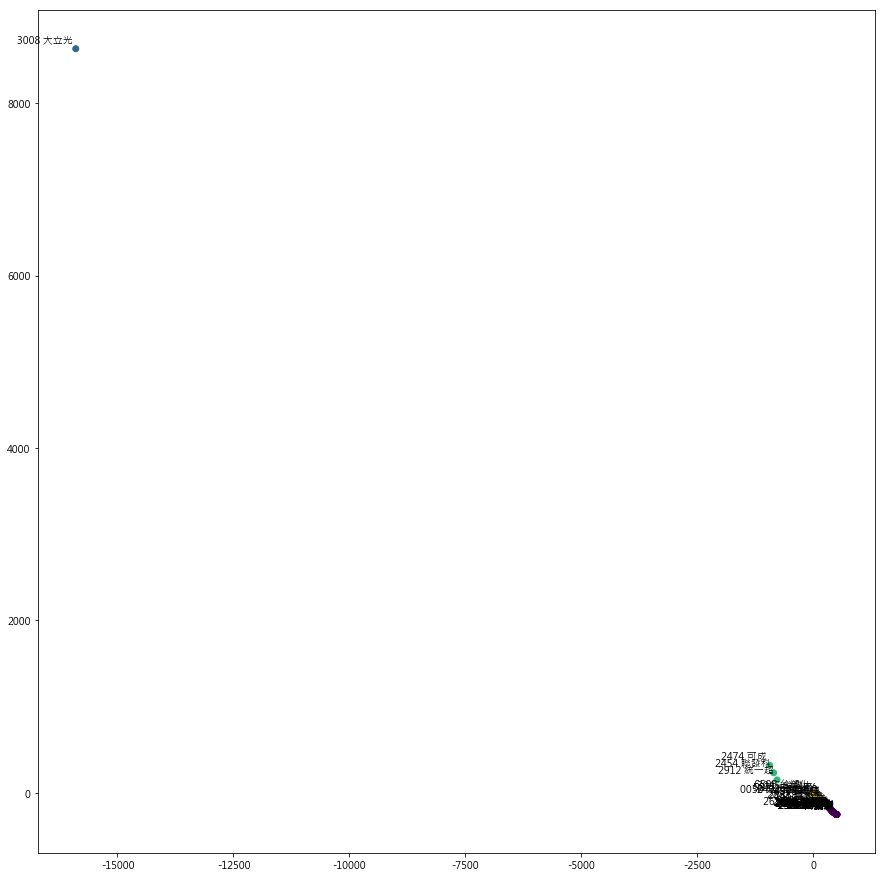

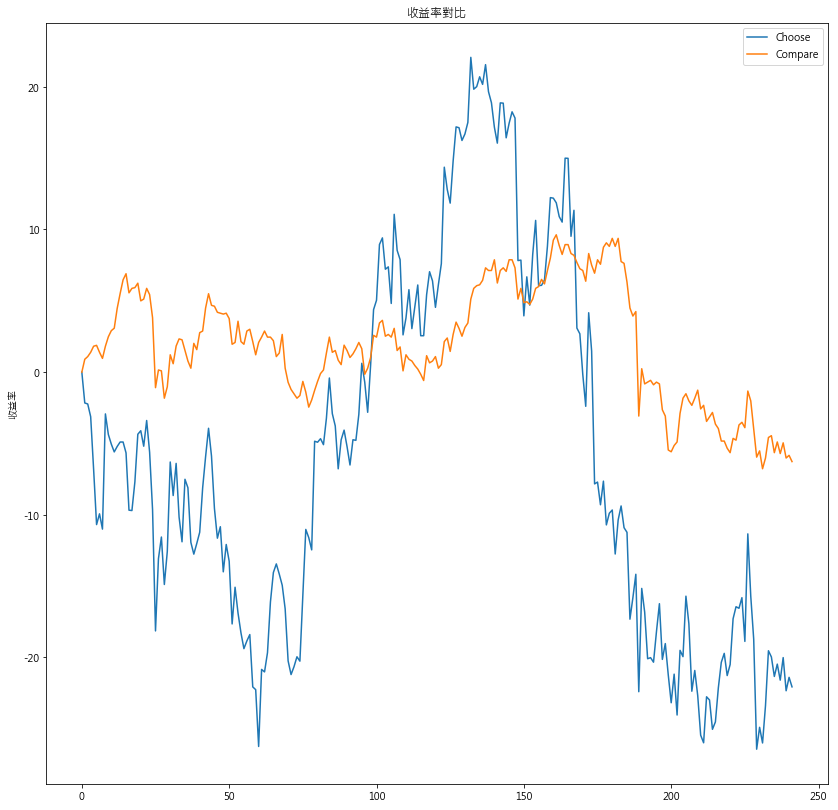

In [15]:
profitVisualize = Mean(K_Means())
profitVisualize.getProfitPicture()

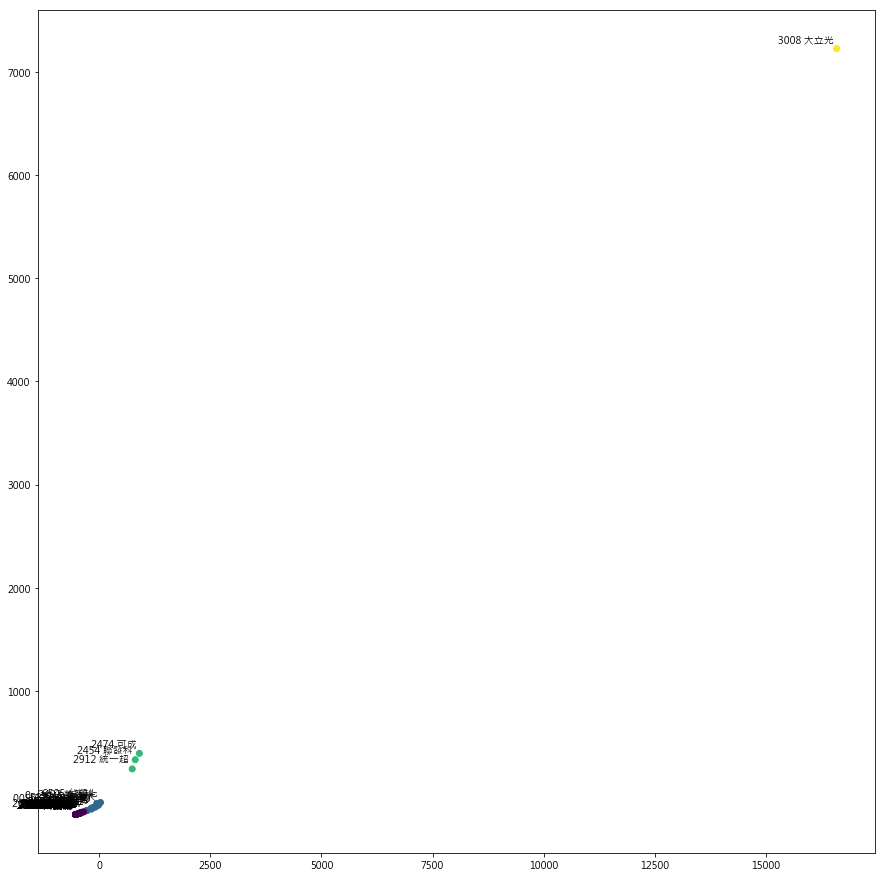

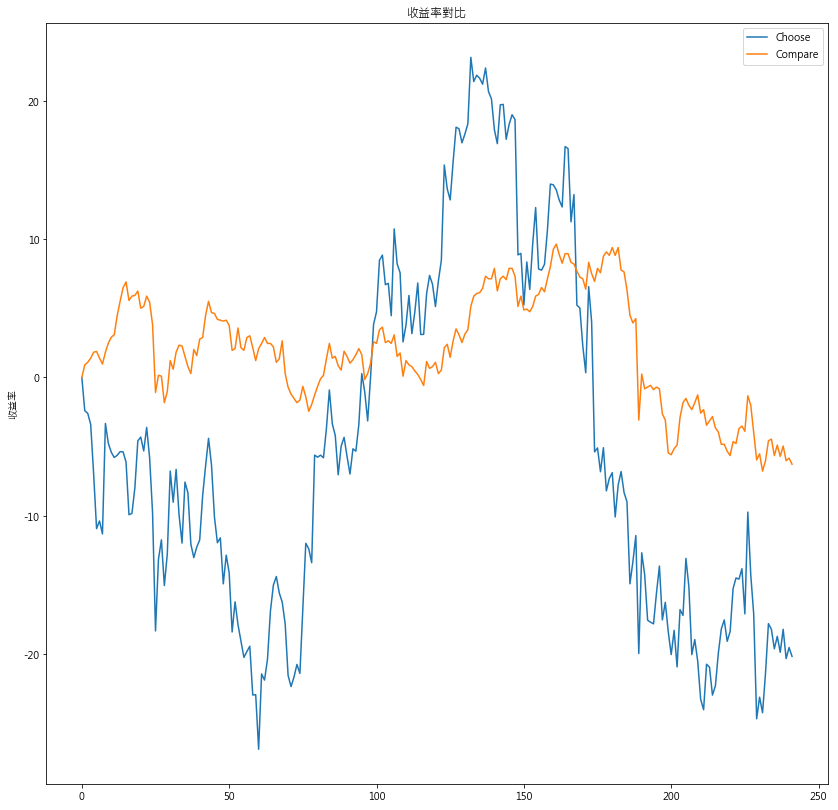

In [16]:
profitVisualize = Mean(Hierarchical())
profitVisualize.getProfitPicture()